In [1]:
import pandas as pd
import numpy as np
import pandas as pd

import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("./stock_historical_data/{}.csv".format("LT.NS"))
df.set_index("Date", inplace=True)
df["date"] = df.index

In [3]:
df

,Open,High,Low,Close,Volume,date
Date,,,,,,
2005-01-03,87.692411,87.692411,84.764939,85.743690,3338964,2005-01-03
2005-01-04,86.024586,86.814608,85.322347,85.515465,1394550,2005-01-04
2005-01-05,85.585686,87.253506,83.110280,84.203148,3575070,2005-01-05
2005-01-06,84.260203,84.268978,82.206147,82.508987,1900755,2005-01-06
2005-01-07,82.601173,86.024597,82.601173,85.541809,2619549,2005-01-07
...,...,...,...,...,...,...
2023-07-12,2480.300049,2485.949951,2451.100098,2472.500000,1081811,2023-07-12
2023-07-12,2480.300049,2485.949951,2451.100098,2454.649902,1320558,2023-07-12
2023-07-12,2480.300049,2485.949951,2451.100098,2455.649902,1439041,2023-07-12


In [3]:
target = []
for i in range(0,len(df)):
    if df.iloc[i].Open > df.iloc[i].Close:
        target.append(0)
    else:
        target.append(1)
df["target"] = target

In [4]:
var_colums = [c for c in df.columns if c not in ['date','']]
X = df.loc[:, var_colums]
y = df.loc[:, 'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((3661, 6), (916, 6), (3661,), (916,))

In [5]:
df1 = pd.DataFrame(df.Close)
df1.reset_index(inplace=True)

In [6]:
df1 = df1.drop("Date",axis=1)
df1

,Close
0,85.743690
1,85.515465
2,84.203148
3,82.508987
4,85.541809
...,...
4572,2472.500000
4573,2454.649902
4574,2455.649902
4575,2450.149902


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [8]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
train_data.shape , test_data.shape

((3661, 1), (916, 1))

In [10]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [12]:
print(X_train.shape), print(y_train.shape)


(3560, 100)
(3560,)


(None, None)

In [13]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

2023-07-18 14:38:55.621349: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=40,batch_size=64,verbose=1)


Epoch 1/40
56/56 [==============================] - 17s 193ms/step - loss: 0.0082 - val_loss: 0.0045
Epoch 2/40
56/56 [==============================] - 8s 150ms/step - loss: 3.5067e-04 - val_loss: 8.6392e-04
Epoch 3/40
56/56 [==============================] - 9s 153ms/step - loss: 2.9290e-04 - val_loss: 8.1675e-04
Epoch 4/40
56/56 [==============================] - 9s 160ms/step - loss: 2.7896e-04 - val_loss: 0.0011
Epoch 5/40
56/56 [==============================] - 9s 159ms/step - loss: 2.5769e-04 - val_loss: 8.3846e-04
Epoch 6/40
56/56 [==============================] - 9s 156ms/step - loss: 2.4750e-04 - val_loss: 8.8010e-04
Epoch 7/40
56/56 [==============================] - 9s 163ms/step - loss: 2.3257e-04 - val_loss: 7.7478e-04
Epoch 8/40
56/56 [==============================] - 9s 168ms/step - loss: 2.2843e-04 - val_loss: 6.2056e-04
Epoch 9/40
56/56 [==============================] - 9s 161ms/step - loss: 2.1564e-04 - val_loss: 6.5917e-04
Epoch 10/40
56/56 [====================

In [18]:
import tensorflow as tf


In [19]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

26/26 [==============================] - 1s 36ms/step


In [20]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

770.4044784355085

In [22]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

1693.3970126138113

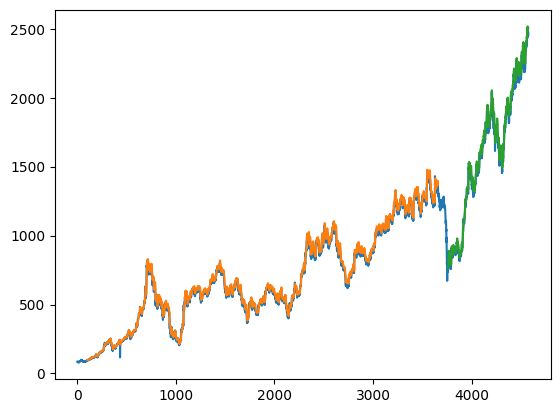

In [23]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()